In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

In [ ]:
df = pd.read_excel('Lithium export Forecasting.xlsx')
df_total = df[df['Country/Region'] == 'Total'].drop(columns=['Country/Region', 'Total'])

In [ ]:
df_long = df_total.melt(var_name='Date_Str', value_name='Value')

In [ ]:
df_long['Date'] = pd.to_datetime(df_long['Date_Str'], format='%b-%Y')
df_long = df_long.sort_values('Date').set_index('Date')
series = df_long['Value']

In [24]:
result = adfuller(series.dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}") # data is stationary d=0

ADF Statistic: -1.8164
p-value: 0.3723


In [ ]:
series

,Value
Date,
2017-01-01,0.55
2017-02-01,0.03
2017-03-01,0.05
2017-04-01,0.27
2017-05-01,0.78
...,...
2024-08-01,1.35
2024-09-01,1.69
2024-10-01,1.78


In [25]:
series_first_diff = series - series.shift(1)

In [26]:
series = series_first_diff

In [27]:
result = adfuller(series_first_diff.dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}") # data is stationary d=1

ADF Statistic: -18.0017
p-value: 0.0000


In [28]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

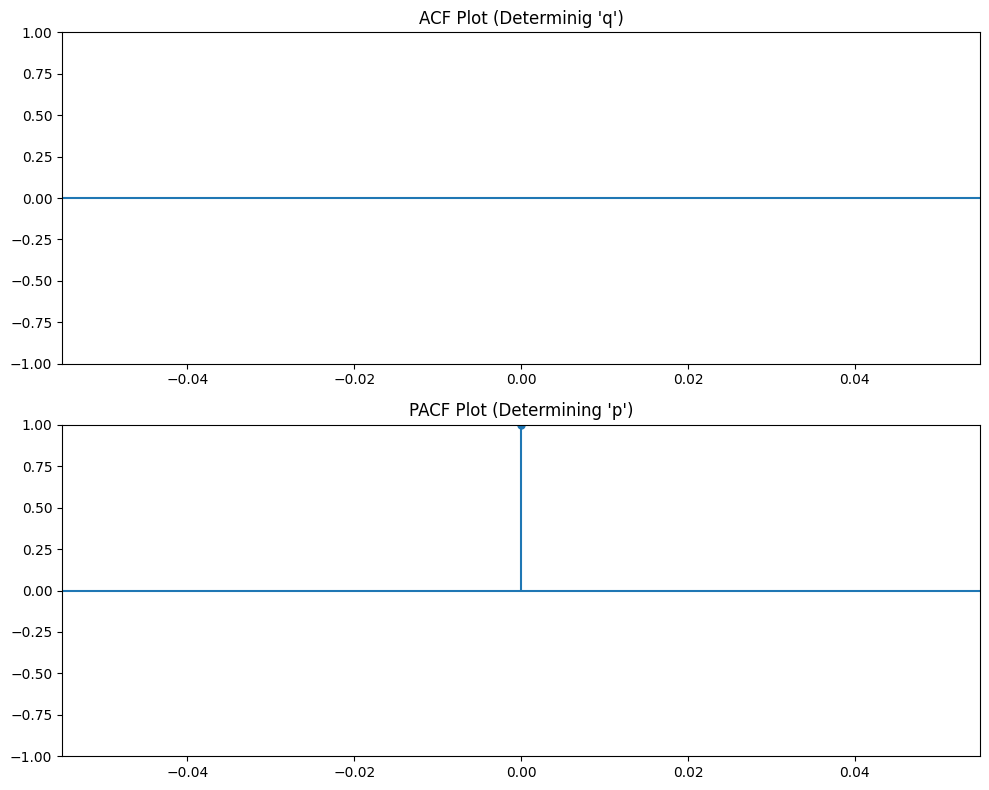

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF (Determine q)
plot_acf(series, lags=20, ax=ax1, title="ACF Plot (Determinig 'q')") # q=3

# Plot PACF (Determine p)
plot_pacf(series, lags=20, ax=ax2, title="PACF Plot (Determining 'p')") # p=2

plt.tight_layout()
plt.show()

# (p,d,q) = (0,1,0) for now

<Figure size 1000x400 with 0 Axes>

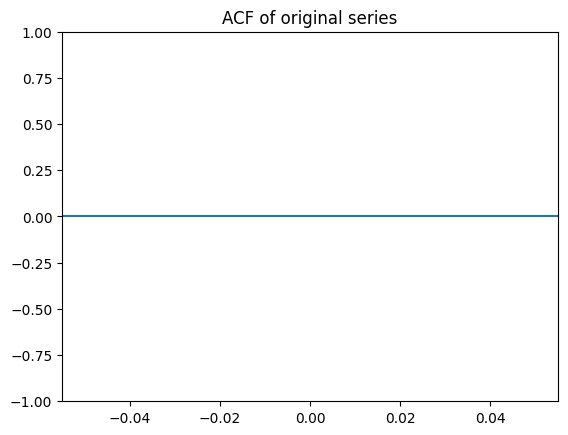

In [30]:
s=12
plt.figure(figsize=(10,4))
plot_acf(series, lags=3*s)
plt.title("ACF of original series")
plt.show()

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

In [32]:
train_data = series.iloc[:-12]
test_data = series.iloc[-12:]

In [41]:
model = SARIMAX(train_data,
                order=(0, 1, 0),
                seasonal_order=(1, 1, 1, 12))

model_fit = model.fit(disp=False)

forecast = model_fit.get_forecast(steps=12)
pred_values = forecast.predicted_mean
conf_int = forecast.conf_int()


rmse = np.sqrt(mean_squared_error(test_data, pred_values))
print(f"Model Performance (RMSE): {rmse:.2f}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Model Performance (RMSE): 0.90


In [43]:
pred_values

,predicted_mean
2024-01-01,0.714857
2024-02-01,0.096379
2024-03-01,0.620608
2024-04-01,0.596061
2024-05-01,0.629658
2024-06-01,1.092934
2024-07-01,0.003516
2024-08-01,0.618323
2024-09-01,0.053828
2024-10-01,1.530157


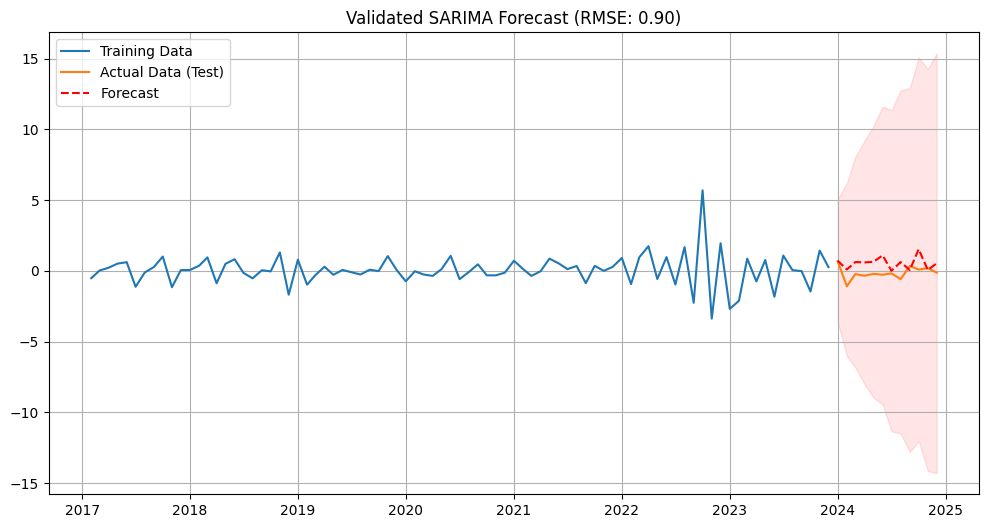

In [34]:
# Plotting the Result
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data (Test)')
plt.plot(test_data.index, pred_values, label='Forecast', color='red', linestyle='--')
plt.fill_between(test_data.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='red', alpha=0.1)
plt.title(f'Validated SARIMA Forecast (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)
plt.show()